# Generating PSFs

This notebook demonstrates how to build a drizzle PSF using sample data included with *Mophongo*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mophongo.psf import DrizzlePSF
from mophongo.templates import _convolve2d
from mophongo.utils import clean_stamp
import mophongo.utils as utils




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Load the drizzle image and WCS info

In [2]:
filt = 'F770W'
#filter_regex = f'UDS_MIRI_{filt}_OS4_GRID1'
filter_regex = f'UDS_MIRI_{filt}_DET_GRID9_OS4'
# for NIRCam you would use e.g. filt = 'F444W'
#filt = 'F444W'
#filter_regex = f'UDS_NRC.._{filt}_OS4_GRID25'
#filter_regex = f'UDS_NRC.._{filt}_DET_GRID25_OS4'
#filter_regex = f'UDS_NRC.._{filt}_OS4'
#filt = 'F115W'
#filter_regex = f'UDS_NRC.._{filt}'
#filter_regex = f'STDPSF_NRC.._{filt}'
data_dir = Path('../data')
drz_file = data_dir / f'uds-test-{filt.lower()}_sci.fits'
csv_file = data_dir / f'uds-test-{filt.lower()}_wcs.csv'

psf_dir = data_dir / 'PSF'
dpsf = DrizzlePSF(driz_image=str(drz_file), csv_file=str(csv_file))
dpsf.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=filter_regex, verbose=True)


Loading ../data/PSF/UDS_MIRI_F770W_DET_GRID9_OS4.fits 292x292x9 MIRI MIRIM F770W 59967.1


## Extract a PSF at a chosen position

Position: [144.8566709  647.11192814], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001017_02101_00001_mirimage_rate.fits[SCI,1]
Position: [160.3291679  650.52309763], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001017_02101_00002_mirimage_rate.fits[SCI,1]
Position: [144.85481726 647.10567035], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001017_04101_00001_mirimage_rate.fits[SCI,1]
Position: [160.32169511 650.53744362], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001017_04101_00002_mirimage_rate.fits[SCI,1]
Position: [816.86897615 651.95654241], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001018_02101_00001_mirimage_rate.fits[SCI,1]
Position: [832.3413312  655.54894305], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001018_02101_00002_mirimage_rate.fits[SCI,1]
Position: [816.8661433  651.96077957], Filter: UDS_MIRI_F770W_DET_GRID9_OS4, in frame: jw01837001018_04101_00001_mirimage_rate.fits[SCI,1]
Position: [832.33807345 655

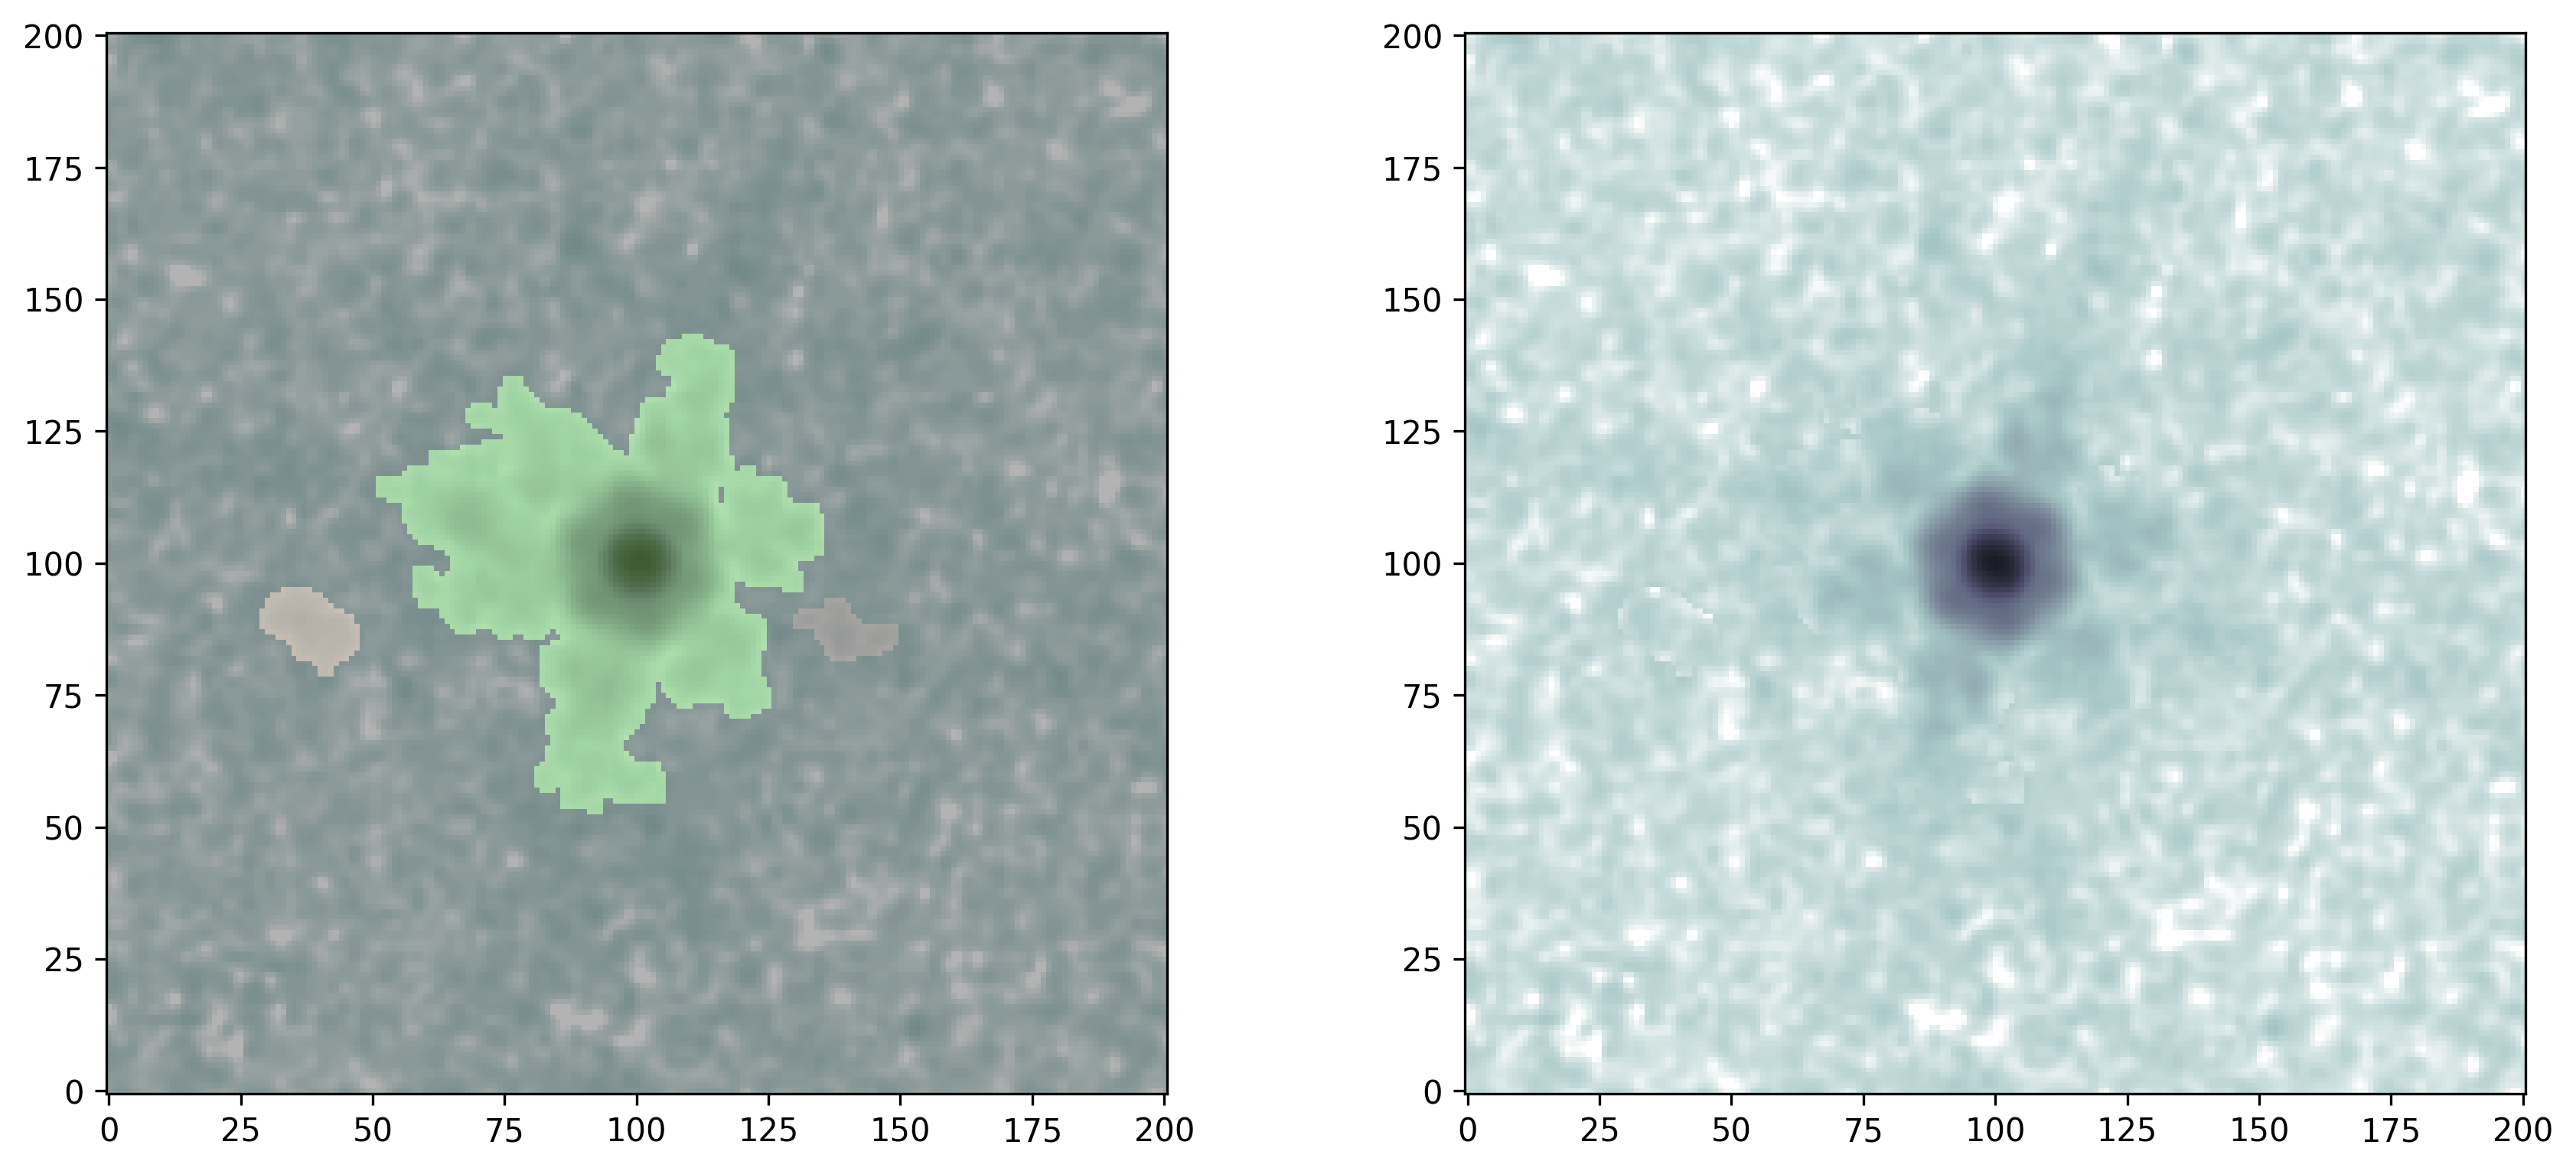

subtracted bg_level: 0.02390739880502224


In [3]:
#%%timeit 

verbose = True
ra, dec = 34.298227, -5.1262533
#ra, dec = 34.30421, -5.1221624
size = 201
Rnorm = 2.0 # in arcsec

cutout_reg = dpsf.get_driz_cutout(ra, dec, size=15, verbose=verbose, recenter=True)
pos_drz, _, _ = dpsf.register(cutout_reg, filter_regex, verbose=verbose)

cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=verbose, recenter=True)
psf_data = dpsf.get_psf(
    ra=pos_drz[0], dec=pos_drz[1],
    filter=filter_regex, wcs_slice=cutout.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'],
    verbose=verbose
)

psf_data, obj, bg_level = clean_stamp(psf_data, verbose=verbose, imshow=False)
cutout_data, obj, bg_level = clean_stamp(cutout.data, verbose=verbose, imshow=verbose)


## Match the PSF to the image and compare

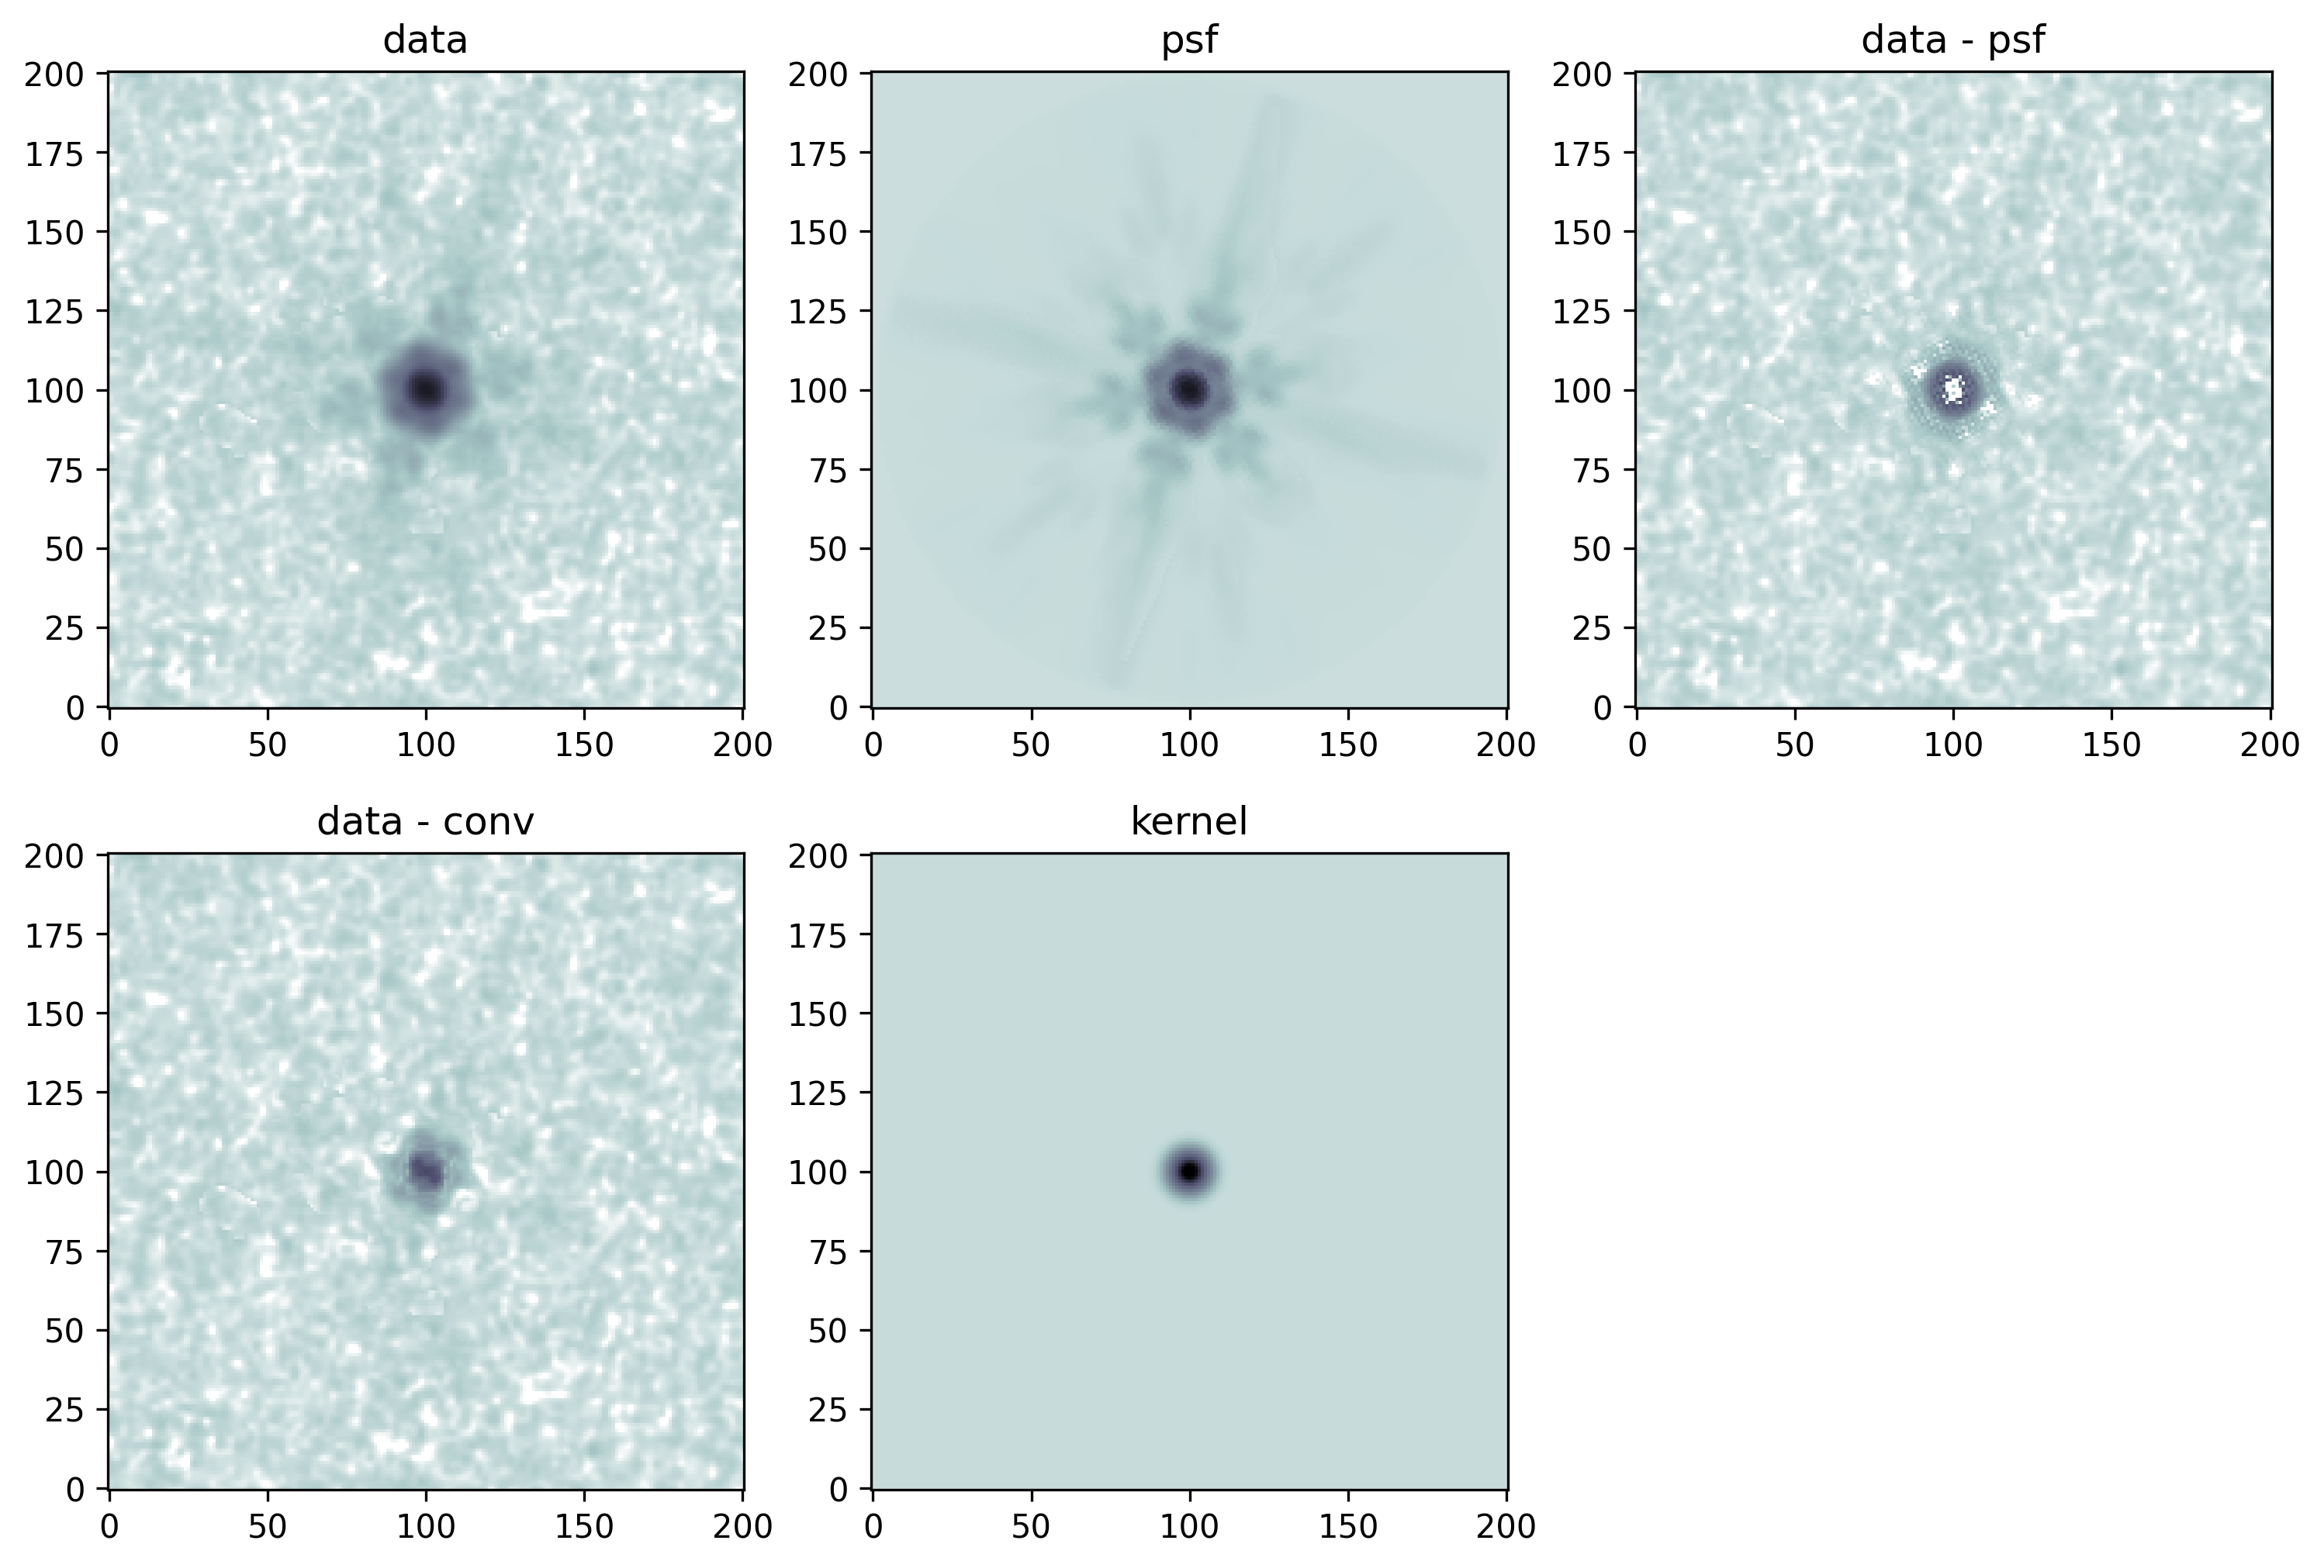

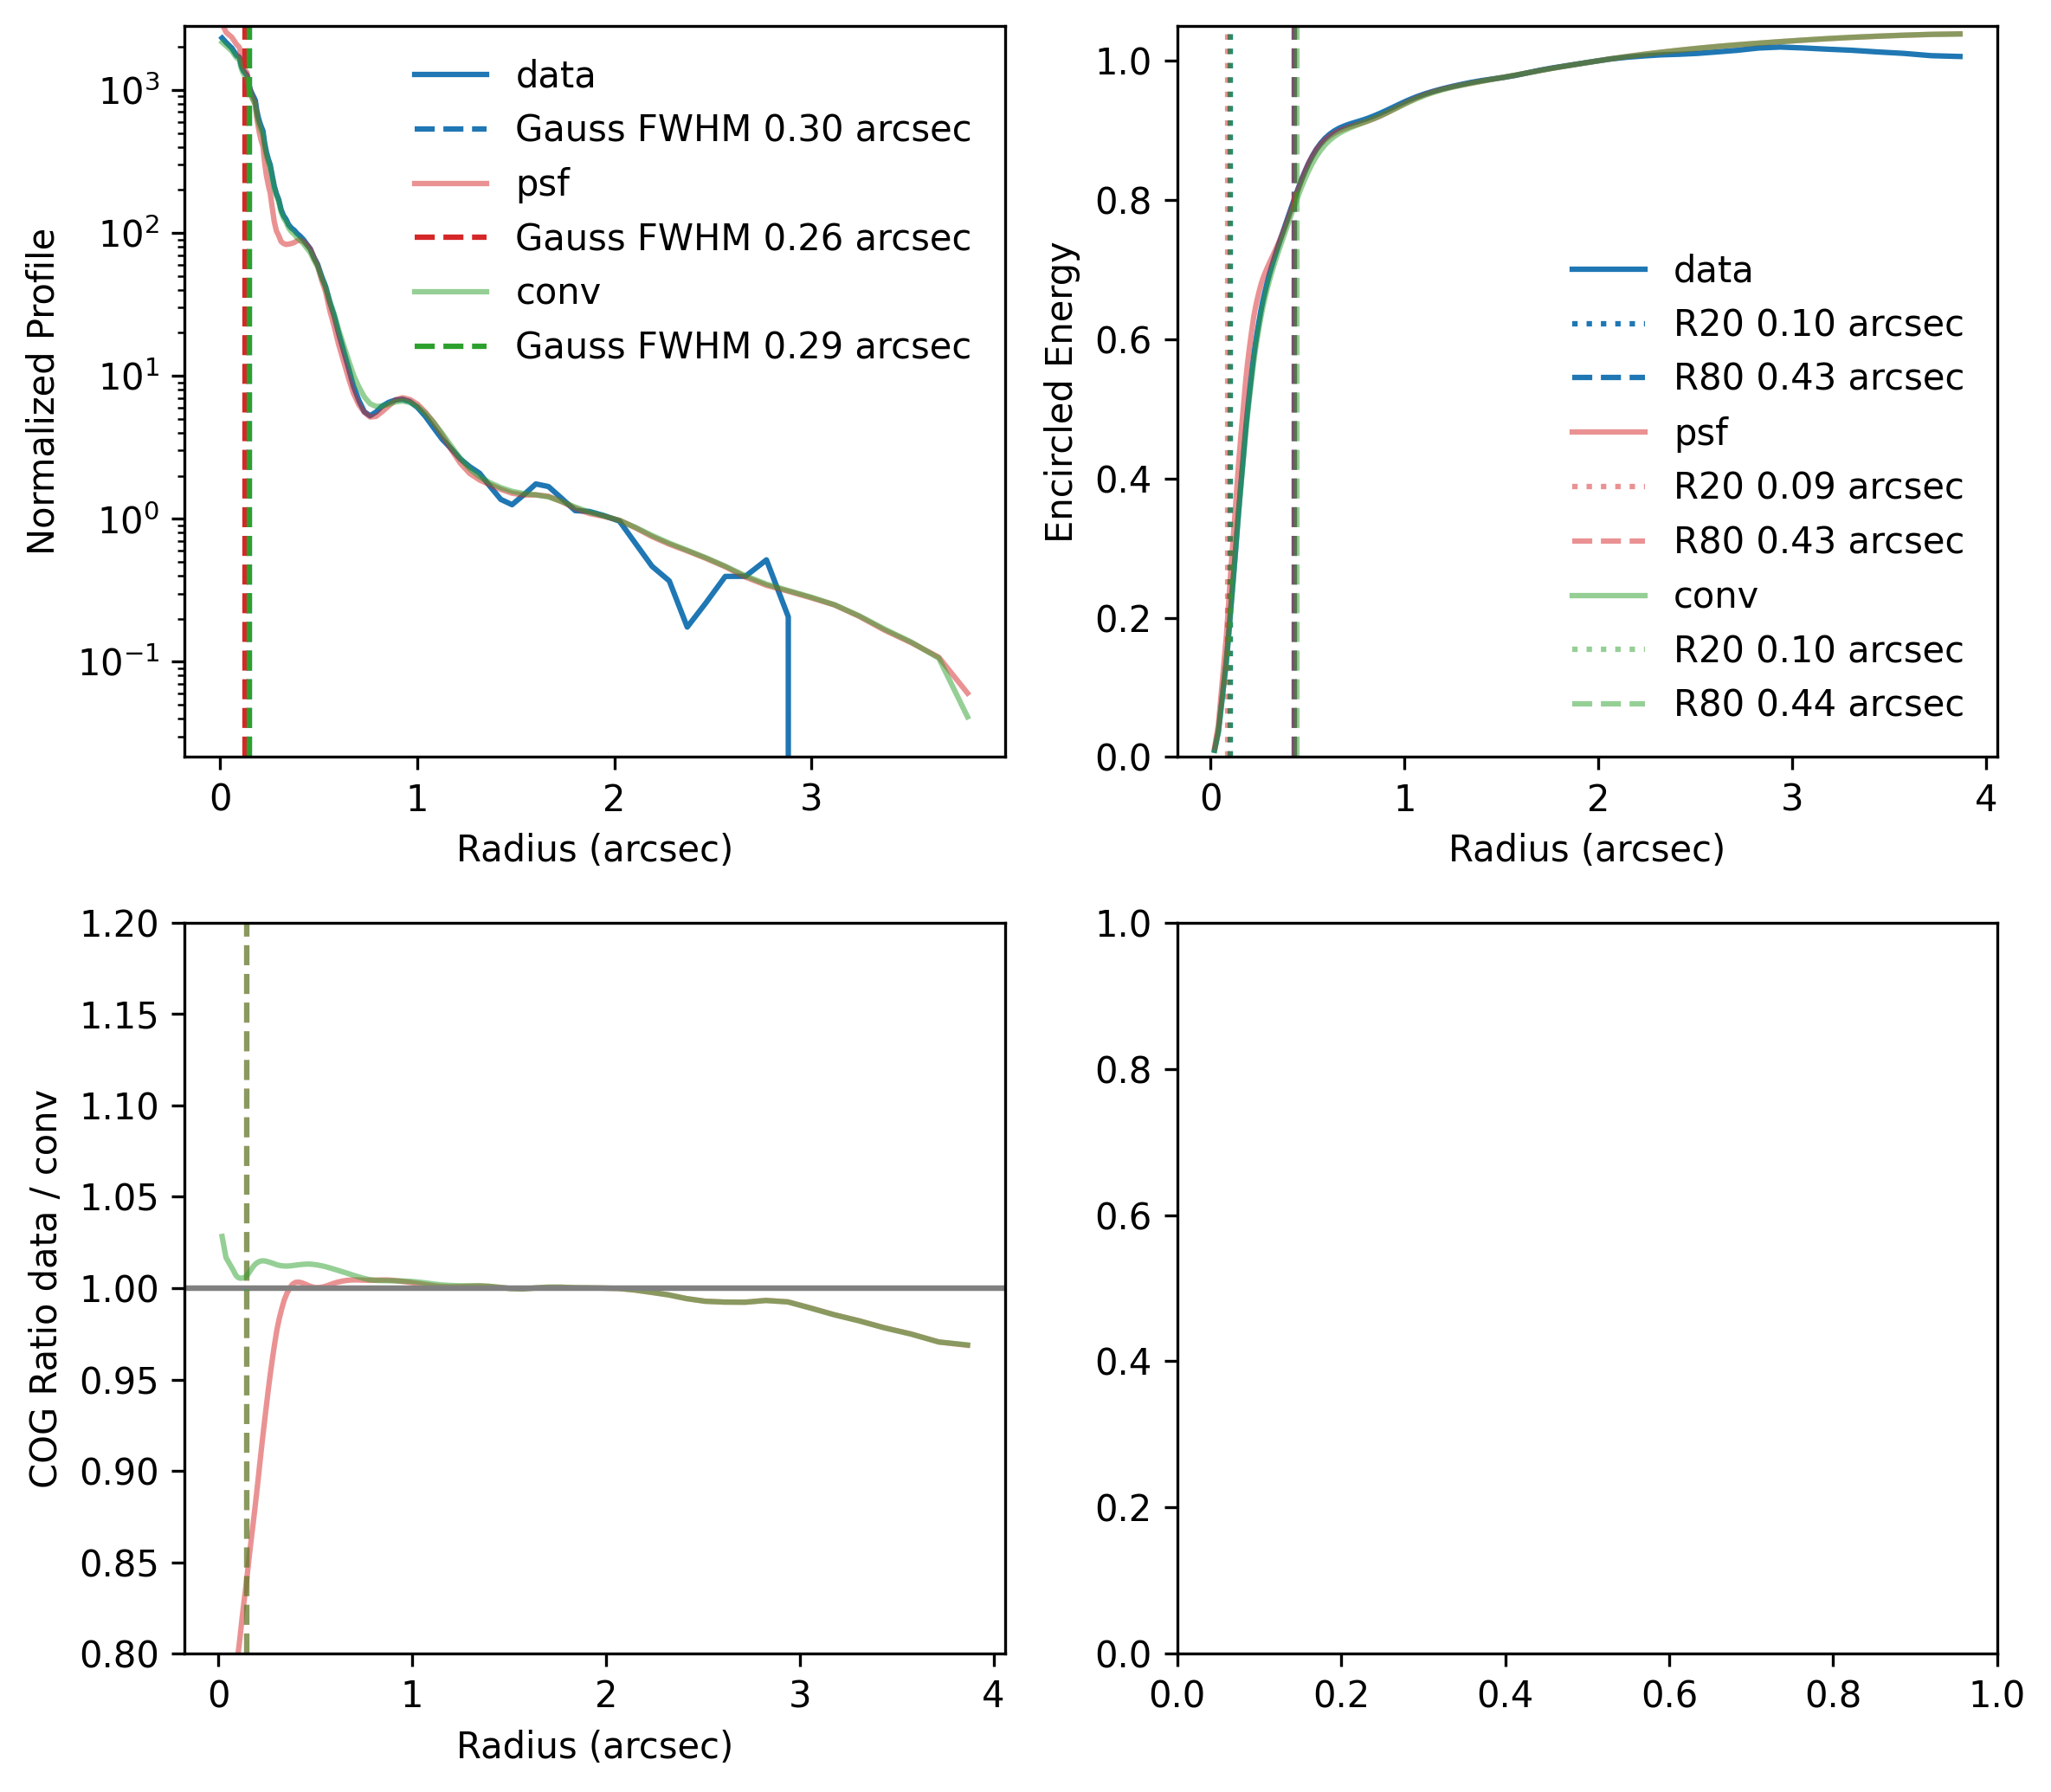

In [ ]:
mask = np.hypot(*np.indices(cutout_data.shape) - cutout_data.shape[0]//2) < (Rnorm / dpsf.driz_pscale)
scl = (cutout_data * psf_data)[mask].sum() / (psf_data[mask]**2).sum()

recenter=True
rp_data = utils.CircularApertureProfile(cutout_data, name='data', 
                                        norm_radius = Rnorm / dpsf.driz_pscale, 
                                        pixel_scale=dpsf.driz_pscale,
                                        recenter=recenter)
rp_psf = utils.CircularApertureProfile(psf_data, name='psf', 
                                       norm_radius = Rnorm / dpsf.driz_pscale, 
                                       pixel_scale=dpsf.driz_pscale,
                                       recenter=recenter)

basis = utils.multi_gaussian_basis([0.5, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0], cutout_data.shape[0])
kernel, coeffs = utils.fit_kernel_fourier(psf_data, cutout_data, basis, method="nnls")
conv = _convolve2d(psf_data, kernel)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
offset = 2e-5
titles = ['data', 'psf', 'data - psf', 'data - conv', 'kernel']
kws = dict(vmin=-5.3, vmax=-1.5, cmap='bone_r', origin='lower')
axes[0].imshow(np.log10(cutout_data/scl + offset), **kws)
axes[1].imshow(np.log10(psf_data + offset), **kws)
axes[2].imshow(np.log10(cutout_data/scl - psf_data + offset), **kws)
axes[3].imshow(np.log10(cutout_data/scl - conv + offset), **kws)
axes[4].imshow(np.log10(kernel + offset), **kws)
axes[5].axis('off')
for i in range(len(titles)):
    axes[i].set_title(titles[i])
plt.show()

rp_conv = utils.CircularApertureProfile(conv, name='psf_conv', 
                                        norm_radius = Rnorm / dpsf.driz_pscale, 
                                        pixel_scale=dpsf.driz_pscale,
                                        recenter=recenter)
fig_rp, axes_rp = rp_data.plot()
_ = rp_data.plot_other(rp_psf, axes = axes_rp, color='C3', alpha=0.5)
_ = rp_data.plot_other(rp_conv, axes = axes_rp, color='C2', alpha=0.5)

#rp_data.plot(compare_to=rp_psf)

